# Geopandas

In [1]:
import geopandas as gpd

ImportError: libpoppler.so.71: cannot open shared object file: No such file or directory

In [5]:
! export SHAPE_RESTORE_SHX YES

In [ ]:
gdf = gpd.read_file('shapefiles/cuenca_lq.shp')

In [29]:
gdf

,NAME,LAYER,KML_STYLE,tessellate,geometry
0,La Quebrada,Unknown Line Type,msn_ylw-pushpin,1,"POLYGON ((4371192.746788587 6554651.651041428,..."


In [ ]:
gdf.plot()

In [36]:
from rasterstats import zonal_stats
import rasterio

ImportError: libpoppler.so.71: cannot open shared object file: No such file or directory

In [35]:
src = rasterio.open('../wrfout_A_d01_2019-03-25_06:00:00')

NameError: name 'rasterio' is not defined

In [17]:
affine = src.transform
array = src.read(1)

NameError: name 'src' is not defined

In [16]:
import pandas as pd
df_zonal_stats = pd.DataFrame(rasterstats.zonal_stats(gdf, src, affine=affine))

NameError: name 'rasterstats' is not defined

In [15]:
class LSMGridReaderWRF(pa.LSMGridReader):
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        self._projection = None
        self._epsg = None
        self._geotransform = None
        self._affine = None
        self._center = None
        self._y_inverted = None

        # set variable information
        self.y_var = 'XLAT'
        self.x_var = 'XLONG'
        self.time_var = 'XTIME'
        # set dimension information
        self.y_dim = 'south_north'
        self.x_dim = 'west_east'
        self.time_dim = 'Time'

        # convert lon from [0 to 360] to [-180 to 180]
        self.lon_to_180 = False
        # coordinates are projected already
        self.coords_projected = False

NameError: name 'pa' is not defined

In [26]:
import pangaea as pa
import xarray as xr

xds =  xr.open_dataset('../../wrfout_d01_2018-05-07_18:00:00')

In [412]:
len(xds.coords['XLAT'].shape)

3

In [349]:
variables = ['XLAT', 'XLONG', 'XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V']
for var in variables:
    if len(xds.coords['XLAT'].shape) > 2:
        xds.coords[var] = xds.coords[var].mean(axis=0)

In [350]:
xds.lsm.to_utm('T2')

KeyError: 'time'

In [47]:
xds.to_netcdf('wrfout.nc')

PermissionError: [Errno 13] Permission denied: b'/home/andres/Gon/wrf-cuenca/wrfout.nc'

In [173]:
plsm = pa.open_mfdataset('wrfout.nc',
                       lat_var='XLAT',
                       lon_var='XLONG',
                       time_var='XTIME',
                       lat_dim='south_north',
                       lon_dim='west_east',
                       time_dim='Time')

/home/andres/anaconda3/envs/gpd/lib/python3.6/site-packages/xarray/backends/api.py:611: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/andres/anaconda3/envs/gpd/lib/python3.6/site-packages/pangaea/read.py:140: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  inplace=True


In [182]:
def to_projection(self, variable, projection):
    """Convert Grid to New Projection.
        Parameters
        ----------
        variable: :obj:`str`
            Name of variable in dataset.
        projection: :func:`osr.SpatialReference`
            Projection to convert data to.
        Returns
        -------
        :func:`xarray.Dataset`
    """
    new_data = []
    for band in range(self._obj.dims[self.time_dim]):
        arr_grid = ArrayGrid(in_array=self._obj[variable][band].values[::-1,:],
                             wkt_projection=self.projection.ExportToWkt(),
                             geotransform=self.geotransform)
        ggrid = arr_grid.to_projection(projection, gdalconst.GRA_Average)
        new_data.append(ggrid.np_array())

    self.to_datetime()
    return self._export_dataset(variable, np.array(new_data),
ggrid)

In [183]:
from osgeo import osr, gdalconst
proj = osr.SpatialReference()
proj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
t2_proj = to_projection(plsm.lsm, 'T2', proj)
t2_proj['lat'] = t2_proj['lat'].sel(x=1)
t2_proj['lon'] = t2_proj['lon'].sel(y=1)
t2_proj = t2_proj.rename({'lat': 'y', 'lon': 'x'})
t2_proj

<xarray.Dataset>
Dimensions:  (time: 34, x: 313, y: 249)
Coordinates:
  * y        (y) float64 -27.52 -27.56 -27.6 -27.64 ... -37.33 -37.37 -37.41
  * x        (x) float64 -68.92 -68.88 -68.84 -68.8 ... -56.56 -56.52 -56.48
  * time     (time) datetime64[ns] 2018-05-07T18:00:00 ... 2018-05-09T03:00:00
Data variables:
    T2       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    proj4:         +proj=longlat +datum=WGS84 +no_defs 
    geotransform:  (-68.93521853009038, 0.03987027621002501, 0.0, -27.4992482...

In [175]:
plsm.lsm._y_inverted = False

In [176]:
plsm.lsm.y_inverted

False

In [184]:
from affine import Affine
g = t2_proj.geotransform
Affine(g[1], g[2], g[0], g[4], g[5], g[3])

Affine(0.03987027621002501, 0.0, -68.93521853009038,
       0.0, -0.03987027621002501, -27.49924827544796)

In [204]:
t2_proj.lsm.projection.ExportToWkt()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

In [186]:
from rasterio.transform import from_origin
from_origin(472137, 5015782,0.5, 0.5)

Affine(0.5, 0.0, 472137.0,
       0.0, -0.5, 5015782.0)

In [206]:
arr = t2_proj.T2[30].values[:,:]
arr[arr == 0] = np.nan

new_dataset = rasterio.open('test1.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            crs=t2_proj.lsm.projection.ExportToWkt(),
                            transform=t2_proj.lsm.affine)

new_dataset.write(arr, 1)
new_dataset.close()

In [122]:
plsm.lsm.to_utm('T2').lat

<xarray.DataArray 'lat' (y: 270, x: 274)>
array([[-27.509483, -27.511035, -27.512575, ..., -27.491404, -27.489708,
        -27.488001],
       [-27.545783, -27.547338, -27.54888 , ..., -27.527676, -27.525978,
        -27.524268],
       [-27.582083, -27.58364 , -27.585185, ..., -27.563948, -27.562247,
        -27.560535],
       ...,
       [-37.189961, -37.192217, -37.194457, ..., -37.163676, -37.161211,
        -37.158729],
       [-37.226168, -37.228428, -37.23067 , ..., -37.199849, -37.197381,
        -37.194896],
       [-37.262375, -37.264638, -37.266883, ..., -37.236021, -37.23355 ,
        -37.231062]])
Coordinates:
    lat      (y, x) float64 -27.51 -27.51 -27.51 -27.51 ... -37.24 -37.23 -37.23
    lon      (y, x) float64 -68.31 -68.27 -68.23 -68.19 ... -56.58 -56.54 -56.49
Dimensions without coordinates: y, x

In [160]:
xr.open_rasterio('test1.tif')

<xarray.DataArray (band: 1, y: 249, x: 313)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -27.52 -27.56 -27.6 -27.64 ... -37.33 -37.37 -37.41
  * x        (x) float64 -68.92 -68.88 -68.84 -68.8 ... -56.56 -56.52 -56.48
Attributes:
    transform:   (0.03987027621002501, 0.0, -68.93521853009038, 0.0, -0.03987...
    crs:         +init=epsg:4326
    res:         (0.03987027621002501, 0.03987027621002501)
    is_tiled:    0
    nodatavals:  (nan,)

In [61]:
plsm.lsm.projection.proj4

AttributeError: type object 'object' has no attribute '__getattr__'

In [193]:
def to_tif(self, variable, time_index, out_path):
        """Dump a variable at a time index to a geotiff.
            Parameters
            ----------
            variable: :obj:`str`
                Name of variable in dataset.
            time_index: int
                0-based time index,
            out_path: :obj:`str`
                Path to output geotiff file,
        """
        from gazar.grid import (geotransform_from_yx, resample_grid,
        utm_proj_from_latlon, ArrayGrid)
        from osgeo import osr, gdalconst
        proj = osr.SpatialReference()
        proj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
        print(proj.ExportToWkt())
        print(self.projection.ExportToWkt())
        print(self.to_utm(variable).geotransform)
        print(self.geotransform)
        arr_grid = ArrayGrid(in_array=self._obj[variable][time_index].values[::-1,:],
                             wkt_projection=proj.ExportToWkt(),
                             geotransform=self.geotransform)
        arr_grid.to_tif(out_path)

In [194]:
to_tif(plsm.lsm, 'RAINNC', 30, 'rainnc30.tif')
to_tif(plsm.lsm, 'T2', 30, 't2_30.tif')

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",-60],PARAMETER["standard_parallel_2",-30],PARAMETER["latitude_of_origin",-32.50000762939453],PARAMETER["central_meridian",-62.70000076293945],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1]]
(-26723.196425305097, 4038.2720057808515, 0.0, 6947904.015708788, 0.0, -4038.2720057808515)
(-538002.6462389242, 4000.0002672614787, 0, 537998.8966371536, 0, -3999.999428244244)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],P

In [271]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterstats import zonal_stats

gdf = gpd.read_file('shapefiles/Cuencas hidrográficas.shp', encoding = 'utf-8')

with rasterio.open("ppn_2018-05-07_18.tif") as src:
    affine = src.transform
    array = src.read(1)
    df_zonal_stats = pd.DataFrame(zonal_stats(gdf, array, affine=affine))

# adding statistics back to original GeoDataFrame
gdf2 = pd.concat([gdf, df_zonal_stats], axis=1) 
gdf2

/home/andres/anaconda3/envs/gpd/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,LAYER,Codigo,Subcuenca,Nombre_Sub,Cuenca,CLOSED,BORDER_STY,BORDER_COL,BORDER_WID,FILL_STYLE,geometry,count,max,mean,min
0,Unknown Area Type,01,01-Sistema San Francisco,Sistema San Francisco,b'R\xedo Pasaje o Salado',YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-62.35513850808535 -31.4498377760944...,39,110.400391,90.631554,43.751831
1,Unknown Area Type,02,02-Cuenca R. Quinto (Popopis),Cuenca R. Quinto (Popopis),b'R\xedo Quinto (Popopis)',YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-65.11130899258225 -33.9131175404837...,94,12.614136,2.357450,0.230347
2,Unknown Area Type,03,03-Sistema A. La Punilla,Cuenca R. Quinto (Popopis),b'R\xedo Quinto (Popopis)',YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-65.14243640060049 -33.1946463438181...,8,5.067261,1.612717,0.201294
3,Unknown Area Type,04,04-Cuenca R. Anizacate,Cuenca R. Anizacate,Lag. Mar Chiquita,YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-64.87730441256126 -31.6369116289113...,63,35.733887,24.172160,12.535278
4,Unknown Area Type,05,b'05-Cuenca A. La Ca\xf1ada',b'Cuenca A. La Ca\xf1ada',Lag. Mar Chiquita,YES,Solid,"RGB(0,0,0)",1,No Fill,"POLYGON ((-64.507650595492 -31.48775614952189,...",18,37.801270,24.841600,13.909058
5,Unknown Area Type,06,b'06-Cuenca R. Sald\xe1n',b'Cuenca R. Sald\xe1n',Lag. Mar Chiquita,YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-64.43028976163957 -31.1392500536354...,14,31.521729,22.181274,17.969604
6,Unknown Area Type,07,07-Cuenca Emb Los Molinos,Cuenca Emb Los Molinos,Lag. Mar Chiquita,YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-64.93432111853934 -31.9363223621638...,54,60.364990,34.517250,9.372925
7,Unknown Area Type,09,09-Cuenca Emb. Piedras Moras,Cuenca Emb. Piedras Moras,b'R\xedo Carcara\xf1\xe1',YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-64.96101127807432 -32.1946635480290...,237,69.629883,28.903984,5.203979
8,Unknown Area Type,10,10-Sistema Laguna del 7,b'\xc1rea sin drenaje superficial',b'R\xedo Quinto (Popopis)',YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-64.22197705119486 -34.2373180169189...,56,8.458374,3.573872,0.936157
9,Unknown Area Type,12,b'12-Sistema Ba\xf1ados del R. Dulce',b'Sistema Ba\xf1ados del R. Dulce',Lag. Mar Chiquita,YES,Solid,"RGB(0,0,0)",1,No Fill,POLYGON ((-63.38420116389798 -29.9872648235768...,267,87.376587,35.687927,3.133667


In [303]:
import datetime



datetime.datetime(2018, 5, 7, 18, 0)

In [67]:
src = rasterio.open("t2_30.tif")
src.xy(5,5)

(-4512.700393510411, 6925693.519676994)

In [394]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open('rainnc30.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('rainnc30-2.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

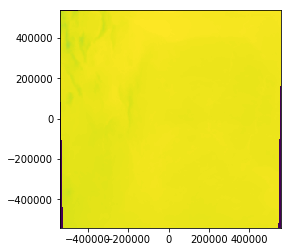

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 274, 'height': 270, 'count': 1, 'crs': CRS({'proj': 'lcc', 'lat_1': -60, 'lat_2': -30, 'lat_0': -32.50000762939453, 'lon_0': -62.70000076293945, 'x_0': 0, 'y_0': 0, 'a': 6370000, 'b': 6370000, 'units': 'm', 'no_defs': True}), 'transform': Affine(4000.0002672614787, 0.0, -538002.6462389242,
       0.0, -3999.999428244244, 537998.8966371536), 'tiled': False, 'interleave': 'band'}

In [371]:
src = rasterio.open("t2_30.tif")
from rasterio.plot import show
show(src.read(1), transform=src.transform, cmap='viridis')
src.profile

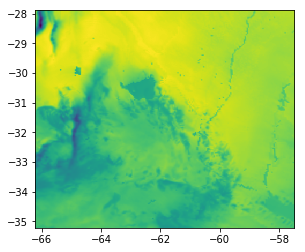

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 485, 'height': 407, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.01801802, 0.0, -66.21643581000001,
       0.0, -0.01801802, -27.886086230000004), 'tiled': False, 'interleave': 'band'}

In [340]:
src = rasterio.open("temp_MAN_12hs.tif")
from rasterio.plot import show
show(src.read(1), transform=src.transform, cmap='viridis')
src.profile

In [301]:
df_zonal_stats

,count,max,mean,min
0,0,None,None,None
1,0,None,None,None
2,0,None,None,None
3,0,None,None,None
4,0,None,None,None
5,0,None,None,None
6,0,None,None,None
7,0,None,None,None
8,0,None,None,None
9,0,None,None,None


In [255]:
gdf2.dropna(subset=['max'])[['PROVINCIA','DEPARTAMTO', 'count', 'max', 'mean', 'min']].sort_values('mean')

,PROVINCIA,DEPARTAMTO,count,max,mean,min


/home/andres/anaconda3/envs/gpd/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/home/andres/anaconda3/envs/gpd/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


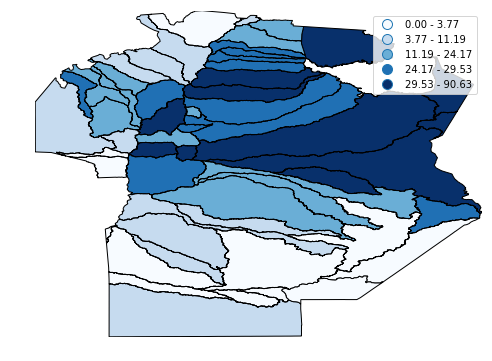

In [209]:
import geoplot
geoplot.choropleth(gdf2.dropna(subset=['max']), hue='mean', cmap='Blues', legend=True)

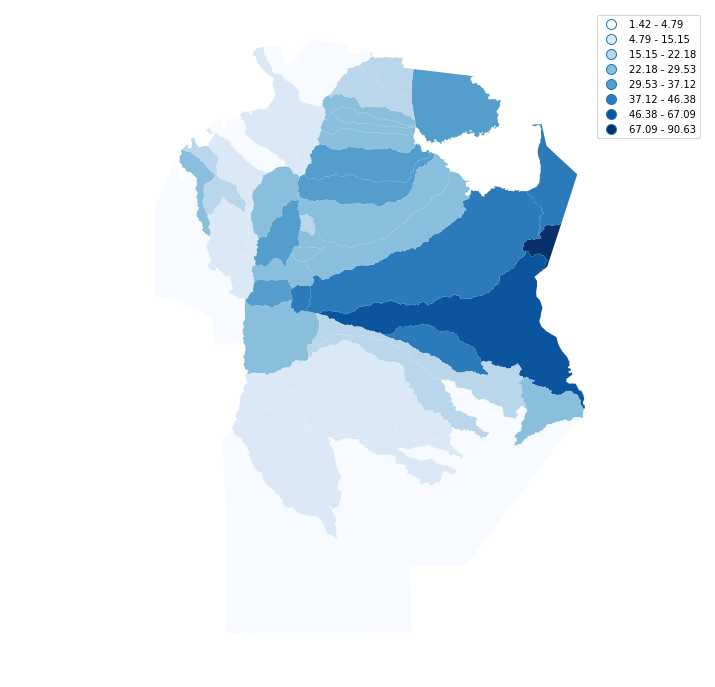

In [304]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(12, 12), frameon=False)
gdf2.dropna(subset=['mean']).plot(column='mean', scheme='fisher_jenks', k=8, 
                         cmap=plt.cm.Blues, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.savefig('a.png',bbox_inches='tight')

In [245]:
nc

NameError: name 'nc' is not defined

In [285]:
from netCDF4 import Dataset
nc = Dataset('../../wrfout_d01_2018-05-07_18:00:00')

In [132]:
import wrf
wrf.LambertConformal()

LambertConformal(stand_lon=None, moad_cen_lat=None, truelat1=None, truelat2=None, pole_lat=None, pole_lon=None)

In [164]:
proj = wrf.LambertConformal(stand_lon=nc.STAND_LON, 
                     moad_cen_lat=nc.MOAD_CEN_LAT, 
                     truelat1=nc.TRUELAT1, 
                     truelat2=nc.TRUELAT2, 
                     pole_lat=nc.POLE_LAT, 
                     pole_lon=nc.POLE_LON)

In [162]:
print(nc.STAND_LON, nc.CEN_LAT, nc.TRUELAT1, nc.TRUELAT2, nc.POLE_LAT, nc.POLE_LON)

-62.7 -32.500008 -60.0 -30.0 90.0 0.0


In [163]:
nc.__dict__

OrderedDict([('TITLE', ' OUTPUT FROM WRF V3.9 MODEL'),
             ('START_DATE', '2018-05-07_18:00:00'),
             ('SIMULATION_START_DATE', '2018-05-07_18:00:00'),
             ('WEST-EAST_GRID_DIMENSION', 270),
             ('SOUTH-NORTH_GRID_DIMENSION', 270),
             ('BOTTOM-TOP_GRID_DIMENSION', 35),
             ('DX', 4000.0),
             ('DY', 4000.0),
             ('SKEBS_ON', 0),
             ('SPEC_BDY_FINAL_MU', 1),
             ('USE_Q_DIABATIC', 0),
             ('GRIDTYPE', 'C'),
             ('DIFF_OPT', 1),
             ('KM_OPT', 4),
             ('DAMP_OPT', 0),
             ('DAMPCOEF', 0.2),
             ('KHDIF', 0.0),
             ('KVDIF', 0.0),
             ('MP_PHYSICS', 8),
             ('RA_LW_PHYSICS', 1),
             ('RA_SW_PHYSICS', 2),
             ('SF_SFCLAY_PHYSICS', 2),
             ('SF_SURFACE_PHYSICS', 2),
             ('BL_PBL_PHYSICS', 2),
             ('CU_PHYSICS', 0),
             ('SF_LAKE_PHYSICS', 0),
             ('SURFACE_IN

In [199]:
proj.cf()

{'grid_mapping_name': 'lambert_conformal_conic',
 'standard_parallel': [-60.0, -30.0],
 'longitude_of_central_meridian': -62.7,
 'latitude_of_projection_origin': -32.500008,
 'semi_major_axis': 6370000.0}

In [168]:
import wrf

mdbz = wrf.getvar(nc, 'mdbz')
mdbz[0,0]

<xarray.DataArray 'max_dbz' ()>
array(-30., dtype=float32)
Coordinates:
    XLONG    float32 -68.91031
    XLAT     float32 -37.21706
    XTIME    float32 0.0
    Time     datetime64[ns] 2018-05-07T18:00:00
Attributes:
    FieldType:      104
    MemoryOrder:    XY
    description:    maximum radar reflectivity
    units:          dBZ
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=-62.70000076293945, moad_cen_l...
    _FillValue:     1e+20
    missing_value:  1e+20

In [203]:
mdbz[0,1]

<xarray.DataArray 'max_dbz' ()>
array(-30., dtype=float32)
Coordinates:
    XLONG    float32 -68.864136
    XLAT     float32 -37.219906
    XTIME    float32 0.0
    Time     datetime64[ns] 2018-05-07T18:00:00
Attributes:
    FieldType:      104
    MemoryOrder:    XY
    description:    maximum radar reflectivity
    units:          dBZ
    stagger:        
    coordinates:    XLONG XLAT XTIME
    projection:     LambertConformal(stand_lon=-62.70000076293945, moad_cen_l...
    _FillValue:     1e+20
    missing_value:  1e+20

In [105]:
mdbz_ds = mdbz.to_dataset()

In [107]:
mdbz_ds.lsm.to_tif('max_dbz', 30, 'mdbz0.tif')

KeyError: 'lat'

In [108]:
mdbz_ds

<xarray.Dataset>
Dimensions:  (south_north: 269, west_east: 269)
Coordinates:
    XLONG    (south_north, west_east) float32 -68.91031 -68.864136 ... -57.32242
    XLAT     (south_north, west_east) float32 -37.21706 ... -27.518177
    XTIME    float32 0.0
    Time     datetime64[ns] 2018-05-07T18:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    max_dbz  (south_north, west_east) float32 -30.0 -30.0 -30.0 ... -30.0 -30.0